### Visualize Points per Annotation (runtime: instant)

In [1]:
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from tqdm import tqdm

#### Set paths
<div class="alert alert-block alert-warning">
<h4>ToDo:</h4>
<ol>
    <li> Set "coda_root" to the root of your <b>CODA directory</b>
    <li> Set "log_finn_root" to the root of your <b>inference directory</b>
    <li> Set "print_values" to <b>True</b> to print the values, <b>False</b> to not print the values
</ol>
</div>

In [2]:
coda_root = f'/disk/ml/own_datasets/CODA'
log_finn_root = f'/disk/vanishing_data/ju878/log_finn/'

print_values = False

In [3]:
model_root = os.path.realpath('../../../model_contradictions/')
create_coda_root = os.path.join(model_root, 'create_coda')

graphics_root = os.path.join(model_root, 'graphics')

lidar_annotation_folder = os.path.join(coda_root, 'lidar_clustering')
lidar_labels = os.path.join(coda_root, 'lidar_labels_annotation')
json_cornercases = os.path.join(coda_root, 'corner_case.json')
annotation_validation = os.path.join(create_coda_root, 'annotation_validation')

In [4]:
with open(annotation_validation, 'r') as f:
    anno_valid = f.read().splitlines()
    
with open(json_cornercases, 'r') as f:
    data_cornercases = json.load(f)
    
annotations = data_cornercases['annotations']

#### Functions to translate manual inspection into labels

Load lidar data with labels and manual inspection clustering

In [5]:
def get_lidar_with_labels(annotation):
    annotation_id = annotation['id']
    annotation_path = os.path.join(lidar_annotation_folder, str(annotation_id) + '.bin')
    clustering = anno_valid[annotation_id - 1]
    
    points = np.fromfile(annotation_path, dtype=np.float32).reshape((-1, 7))
     
    return points, clustering

Set labels according to manual inspection

In [6]:
def set_labels(points, clustering):
    labels = np.ones((points.shape[0], 1))
    if clustering == 1:
        # set dbscan
        labels[:, 0] = points[:, 4]
    elif clustering == 2:
        # set mean shift
        labels[:, 0] = points[:, 6]
    elif clustering == 3:
        # set dbscan
        labels[:, 0] = points[:, 4]
    elif clustering == 4:
        # set combined dbscan and mean shift
        for index, point in enumerate(points):
            if point[4] == 1 or point[6] == 1:
                labels[index, 0] = 1
            else:
                labels[index, 0] = -1
    elif clustering == 5:
        # set negated dbscan
        labels[:, 0] = -points[:, 4]
    elif clustering == 6:
        # keep all points as 1
        labels = labels
    elif clustering == 7:
        # keep all points as 1
        labels = labels
    elif clustering == 8:
        # set negated mean shift
        labels[:, 0] = -points[:, 6]
    elif clustering == 9:
        # keep all points as 1
        labels = labels
    return np.hstack([points[:, :3], labels])

Print Points per Annotation

In [7]:
def print_output(once_no_anno_sum, kitti_no_anno_sum, nuscenes_no_anno_sum, once_anno_sum, kitti_anno_sum, nuscenes_anno_sum):
    print('Average points, no Anomaly:')
    print('ONCE: ' + (str(sum(once_no_anno_sum) / len(once_no_anno_sum))))
    print('KITTI: ' + (str(sum(kitti_no_anno_sum) / len(kitti_no_anno_sum))))
    print('nuScenes: ' + (str(sum(nuscenes_no_anno_sum) / len(nuscenes_no_anno_sum))) + '\n')

    print('Average points, Anomaly:')
    print('ONCE: ' + (str(sum(once_anno_sum) / len(once_anno_sum))))
    print('KITTI: ' + (str(sum(kitti_anno_sum) / len(kitti_anno_sum))))
    print('nuScenes: ' + (str(sum(nuscenes_anno_sum) / len(nuscenes_anno_sum))) + '\n')

    print('Median points, Anomaly:')
    print('ONCE: ' + (str(once_anno_sum[int(len(once_anno_sum)/2)])))
    print('KITTI: ' + (str(kitti_anno_sum[int(len(kitti_anno_sum)/2)])))
    print('nuScenes: ' + (str(nuscenes_anno_sum[int(len(nuscenes_anno_sum)/2)])) + '\n')

    print('Ratio: Anomaly Points / Total Points:')
    print('ONCE: ' + (str(sum(once_anno_sum) / (sum(once_anno_sum) + sum(once_no_anno_sum)))))
    print('KITTI: ' + (str(sum(kitti_anno_sum) / (sum(kitti_anno_sum) + sum(kitti_no_anno_sum)))))
    print('nuScenes: ' + (str(sum(nuscenes_anno_sum) / (sum(nuscenes_anno_sum) + sum(nuscenes_no_anno_sum)))) + '\n')

Plot Points per Annotation

In [8]:
def plot_graph(once_anno_sum, kitti_anno_sum, nuscenes_anno_sum):
    plt.boxplot([once_anno_sum, kitti_anno_sum, nuscenes_anno_sum], labels=['CODA-ONCE', 'CODA-KITTI', 'CODA-nuScenes'], showfliers=False, medianprops=dict(color='None'))

    plt.hlines(np.mean(once_anno_sum), 0.85, 1.15, colors='r', linewidth=1, linestyle='--', label=f'Mean ONCE: {round(np.mean(once_anno_sum),2)}')
    plt.hlines(np.median(once_anno_sum), 0.85, 1.15, colors='r', linewidth=1, linestyle='-', label=f'Median ONCE: {round(np.median(once_anno_sum),2)}')
    plt.hlines(np.mean(kitti_anno_sum), 1.85, 2.15, colors='g', linewidth=1, linestyle='--', label=f'Mean KITTI: {round(np.mean(kitti_anno_sum),2)}')
    plt.hlines(np.median(kitti_anno_sum), 1.85, 2.15, colors='g', linewidth=1, linestyle='-', label=f'Median KITTI: {round(np.median(kitti_anno_sum),2)}')
    plt.hlines(np.mean(nuscenes_anno_sum), 2.85, 3.15, colors='b', linewidth=1, linestyle='--', label=f'Mean nuScenes: {round(np.mean(nuscenes_anno_sum),2)}')
    plt.hlines(np.median(nuscenes_anno_sum), 2.85, 3.15, colors='b', linewidth=1, linestyle='-', label=f'Median nuScenes: {round(np.median(nuscenes_anno_sum),2)}')

    plt.xlabel('Datasets')
    plt.ylabel('Number of Points')
    plt.yscale('log')
    plt.ylim(bottom=1, top=2000)
    plt.legend()

    plt.savefig(os.path.join(graphics_root, 'point_distribution_annotations.svg'), format='svg', dpi=1200)
    plt.show()
    plt.close()

#### Create Points per Annotation and print/plot

100%|██████████| 5937/5937 [00:03<00:00, 1790.82it/s]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


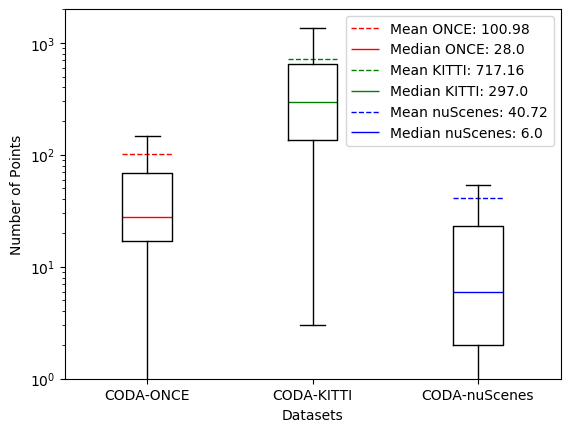

In [9]:
once_anno_sum = []
kitti_anno_sum = []
nuscenes_anno_sum = []
once_no_anno_sum = []
kitti_no_anno_sum = []
nuscenes_no_anno_sum = []

for annotation in tqdm(annotations):
        id = annotation['id']
        annotations_in_lidar = np.array([-1,-1,-1,-1])
        
        if id > 4413 and id <= 4812:
            points, clustering = get_lidar_with_labels(annotation)
            points = set_labels(points, int(clustering))
            kitti_anno_sum.append(len(np.where(points[:, 3] == 1)[0]))
            kitti_no_anno_sum.append(len(np.where(points[:, 3] == -1)[0]))
            
        elif id > 4812:
            points, clustering = get_lidar_with_labels(annotation)
            points = set_labels(points, int(clustering))
            nuscenes_anno_sum.append(len(np.where(points[:, 3] == 1)[0]))
            nuscenes_no_anno_sum.append(len(np.where(points[:, 3] == -1)[0]))
        elif id <= 4413:
            points, clustering = get_lidar_with_labels(annotation)
            points = set_labels(points, int(clustering))
            once_anno_sum.append(len(np.where(points[:, 3] == 1)[0]))
            once_no_anno_sum.append(len(np.where(points[:, 3] == -1)[0]))

once_anno_sum = sorted(once_anno_sum, reverse=True)
kitti_anno_sum = sorted(kitti_anno_sum, reverse=True)
nuscenes_anno_sum = sorted(nuscenes_anno_sum, reverse=True)
once_no_anno_sum = sorted(once_no_anno_sum, reverse=True)
kitti_no_anno_sum = sorted(kitti_no_anno_sum, reverse=True)
nuscenes_no_anno_sum = sorted(nuscenes_no_anno_sum, reverse=True)

if print_values:
    print_output(once_no_anno_sum, kitti_no_anno_sum, nuscenes_no_anno_sum, once_anno_sum, kitti_anno_sum, nuscenes_anno_sum)

plot_graph(once_anno_sum, kitti_anno_sum, nuscenes_anno_sum)